https://www.kaggle.com/c/tweet-sentiment-extraction

# Tweet Sentiment Extraction

"My ridiculous dog is amazing." [sentiment: positive]

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?

In this competition we've extracted support phrases from Figure Eight's Data for Everyone platform. The dataset is titled Sentiment Analysis: Emotion in Text tweets with existing sentiment labels, used here under creative commons attribution 4.0. international licence. Your objective in this competition is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

*Run with Google Colab and enable accelerated hardware (GPU)*

Confirm that can connect GPU with Tensorflow

In [0]:
!pip install tensorflow-gpu==2.1.0

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

*Note*: make sure to use tensorflow version 2.1.0 for ktrain to work properly. Otherwise, `from ktrain import text` throws an error (hasn't been made compatible with tf 2.2)

In [4]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip3 install -q ktrain

In [0]:
from ktrain import text

# **Classifier**: Use Hugging Face Transformer (DistilBERT) to see contributions of each word/expression to tweet sentiment classification

## 1 - Load data

In [5]:
import ktrain
from google.colab import files
import io
import pandas as pd

# import train
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train (1).csv
User uploaded file "train.csv" with length 3501243 bytes


In [0]:
# read in as dataframe
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [8]:
# import test
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test (1).csv
User uploaded file "test.csv" with length 313984 bytes


In [0]:
# read in as dataframe
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

In [12]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [13]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [21]:
print(f'size of train set: {train.shape[0]}')
print(f'size of validation set: {test.shape[0]}')

size of train set: 27481
size of validation set: 3534


In [10]:
# drop nan at row index 314

train.dropna(axis=0, inplace=True)
print(f'size of train set: {train.shape[0]}')

size of train set: 27480


In [0]:
# tweet sentiments are classified into 3 categories
categories = ['positive', 'neutral', 'negative']

x_train = train['text'].to_list()
y_train = train['sentiment'].to_list()
x_test = test['text'].to_list()
y_test = test['sentiment'].to_list()

### optional: label encoding

Optional: label encoding of targets, but not needed for preprocessing in ktrain

In [0]:
# try label encoding Y

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# negative = 0, neutral = 1, positive =2
le.fit(categories)
train['sentiment_le'] = le.transform(train['sentiment'])

y_train = train['sentiment_le'].to_numpy()

## 2 - Instantiate Transformer object with desired model

"The **BERT** model represents one of the major AI breakthroughs of 2018–2019 by achieving state-of-the-art performance across 11 different natural language processing tasks." We'll be using a distilled version of the base BERT model for computational purposes, DistilBERT (uncased, English language), created and made available by the Hugging Face project

In [0]:
from ktrain import text

MODEL_NAME = 'distilbert-base-uncased'

# create Transformer instance
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=categories)

## 3 - Preprocess data

Note: null values were throwing exception error before, there was a single one in the training dataset that was subsequently dropped


In [25]:
# preprocess datasets into format expected by selected pretrained model
# with try except block 
for i in range(train.shape[0]):
  num_exc = 0
  try:
    trn = t.preprocess_train(x_train[:i+1], y_train[:i+1], verbose=0)
  except:
    num_exc +=1
    if num_exc == 1:
      print(f'The first row to throw exception is row {i}. Text is \'{x_train[i]}\', and sentiment is \'{y_train[i]}\' ')

    continue

In [79]:
# preprocess datasets into format expected by selected pretrained model
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 28


preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 28


## 4 - Create model

In [0]:
# Create a model with pretrained weights and randomly initialized final layers that can be fine tuned later
# and Wrap in ktrain Learner object that will allow us to easily train and inspect the model + make predictions on new data
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

## 5 - Optimize learning rate

simulating training for different learning rates... this may take a few moments...
Train for 4580 steps
Epoch 1/2
4580/4580 [==============================] - 2232s 487ms/step - loss: 0.8601 - accuracy: 0.5917
Epoch 2/2
2342/4580 [==============>...............] - ETA: 18:14 - loss: 1.1374 - accuracy: 0.3965

done.


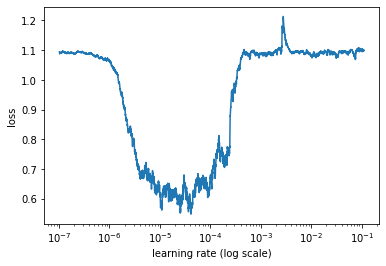

In [82]:
# estimate learning rate
learner.lr_find(show_plot=True, max_epochs=2)

In [0]:
# visual inspection
learn_rate = 1e-5

## 6 - Fit training data

Can additionally chose a schedule policy for learning rate, in this case we'll use one cyle (but there's also triangualar, etc...) to describe a gradual increase and then decay of learning rate. Usually works well for transformer models. 

In [84]:
num_epochs = 4
learner.fit_onecycle(learn_rate, num_epochs)



begin training using onecycle policy with max lr of 1e-05...
Train for 4580 steps, validate for 111 steps
Epoch 1/4
4580/4580 [==============================] - 2332s 509ms/step - loss: 0.6835 - accuracy: 0.7060 - val_loss: 0.5312 - val_accuracy: 0.7716
Epoch 2/4
4580/4580 [==============================] - 2329s 509ms/step - loss: 0.5016 - accuracy: 0.7981 - val_loss: 0.5201 - val_accuracy: 0.7949
Epoch 3/4
4580/4580 [==============================] - 2316s 506ms/step - loss: 0.4066 - accuracy: 0.8408 - val_loss: 0.5095 - val_accuracy: 0.7861
Epoch 4/4
4580/4580 [==============================] - 2322s 507ms/step - loss: 0.2791 - accuracy: 0.8997 - val_loss: 0.5758 - val_accuracy: 0.7920


## 7 - Evaluate model

In [85]:
learner.validate(class_names=categories)

              precision    recall  f1-score   support

    positive       0.78      0.80      0.79      1001
     neutral       0.75      0.77      0.76      1430
    negative       0.86      0.81      0.83      1103

    accuracy                           0.79      3534
   macro avg       0.80      0.79      0.80      3534
weighted avg       0.79      0.79      0.79      3534



array([[ 804,  180,   17],
       [ 199, 1098,  133],
       [  24,  182,  897]])

Not great scores, how can we improve?

## 8 - Predictions with weighted probabilities and check of which words/expressions contribute most to classification

Instantiate predictor object

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

Predict an example from the training dataset

In [94]:
entry = 1
x_train[entry]

' Sooo SAD I will miss you here in San Diego!!!'

In [95]:
# prediction
predictor.predict(x_train[entry])

'negative'

In [96]:
# predicted probability scores for each category (neg, neutral, pos)
predictor.predict_proba(x_train[entry])

array([0.98957497, 0.00630992, 0.00411519], dtype=float32)

In [97]:
# ground truth
y_train[entry]

'negative'

Which words/expression contribute most to classification?

In [89]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [98]:
# explain predictions of classifier, using LIME: https://github.com/marcotcr/lime 
# and eli5 library https://eli5.readthedocs.io/en/latest/blackbox/lime.html
predictor.explain(x_train[entry])

In [99]:
# ground truth for selected text
train['selected_text'][entry]

'Sooo SAD'

Essence or key word is captured, but not the complete expression. If the selected sentence consists of just one word, picks it up pretty well, but if it's longer then has more trouble completing the expression.

## 9 - Save the model

In [0]:
predictor.save('/tmp/tweets_distilber')

In [0]:
# to reload, run reloaded_predictor = ktrain.load_predictor('/tmp/tweets_distilbert')

# Try with Question-Answering

Make sure null is dropped from `train` and `x_train`, `y_train`, `x_test`, and `y_test` are read in (from above section)

In [11]:
x_train[:5]

[' I`d have responded, if I were going',
 ' Sooo SAD I will miss you here in San Diego!!!',
 'my boss is bullying me...',
 ' what interview! leave me alone',
 ' Sons of ****, why couldn`t they put them on the releases we already bought']

In [12]:
x_test[:5]

['Last session of the day  http://twitpic.com/67ezh',
 ' Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).',
 'Recession hit Veronique Branquinho, she has to quit her company, such a shame!',
 ' happy bday!',
 ' http://twitpic.com/4w75p - I like it!!']

In [0]:
# question --> sentiment
# context --> text
# answer --> selected_text

**Simple transformers**: built on top of the Hugging Face Transformers library, so can use any of the transformers they have. 

In [0]:
!pip install simpletransformers

## 1 - Set up training dataset from tweets (train) data

Have to convert our text data to SQuAD style for it to be used in training (and evaluation). Saved as JSON files (Python list of dictionaries). Each dictionary contains two attributes: `context`(str) and `qas` (list of questions + answers). Each dictionary in `qas` contains `id` (str), `question`(str), `is_impossible`(bool), `answers` (list). Each `answers` contains `answer` (str) as a substring of the context and `answer_start`(int) as the starting index of the answer in context. 

In [28]:
for header in train:
  print(header)
  # textID (line[0]) : id
  # text (line[1]) : context
  # selected_text (line[2]) : answer
  # sentiment (line[-1] or line[3]) : question

textID
text
selected_text
sentiment


In [0]:
import numpy as np

In [0]:
# convert to numpy array
train_array = np.array(train)

In [0]:
output = {} #start dictionary

# SQuAD dataset additionally contains version key along with the data
output['version'] = 'v1.0'
output['data'] = []

for row in train_array:
  q_id, context, answer, question = row[0], row[1], row[2], row[3]
  answer_list = []
  qu_ans = []
  paragraphs = [] # context, question, and answer

  #answer_search = start_index(context, answer)
  start_index = context.lower().find(answer.lower()) # returns index
  
  #for a in answer_search:
  answer_list.append({'answer_start': start_index, 'text': answer})

  qu_ans.append({'question': question, 'id': q_id, 'is_impossible':False, 'answers': answer_list})
  paragraphs.append({'context': context, 'qas': qu_ans})

  output['data'].append({'title': 'None', 'paragraphs': paragraphs})

In [0]:
# save as json file
import json
import os

directory = 'tweets_qa'
filename = 'train.json'

if not os.path.exists(directory):
  os.makedirs(directory)

with open(os.path.join(directory, filename), 'w') as outfile:
  json.dump(output, outfile)

In [0]:
with open('tweets_qa/train.json', 'r') as f:
  train_data = json.load(f)

train_data = [item for topic in train_data['data'] for item in topic['paragraphs']]

## 2 - Instantiate model and set hyperparams

For more details on simple transformer's Question answering: https://github.com/ThilinaRajapakse/simpletransformers#question-answering 

For a list of Hugging Face's pretrained models: https://huggingface.co/transformers/pretrained_models.html

In [0]:
from simpletransformers.question_answering import QuestionAnsweringModel

# TODO: tune hyperparameters
train_args = {
    'learning_rate': 3e-5,
    'num_training_epochs': 2,
    'max_seq_length': 128,
    'doc_stride': 128,
    'overwrite_output_dir': True,
    'reprocess_input_data': False,
    'train_batch_size': 2,
    'gradient_accumulation_steps': 8,
    'output_dir': 'tweets_qa/'
}

# specify model type and model name
model = QuestionAnsweringModel('distilbert', 'distilbert-base-uncased', args=train_args)

## 3 - Training

In [0]:
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [30]:
# train model on our dataset
with tf.device('/device:GPU:0'):
  model.train_model(train_data)

Could not find answer: 'Glad' vs. 'glad'
Could not find answer: 'Hope' vs. 'hope'
Could not find answer: 'HAPPY' vs. 'Happy'
Could not find answer: 'Problems,' vs. 'problems,'
Could not find answer: 'yay' vs. 'YAY'
Could not find answer: 'good' vs. 'Good'
100%|██████████| 27474/27474 [00:29<00:00, 939.34it/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 4.834851

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:113: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 2.306552

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 2.885510Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 2.706315Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 2.905444Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 1.807669Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 2.077010Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 1.057153Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 2.103074Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 1.972025



final model is saved to `model.args['output_dir']`

## 4 - Evaluation

In [31]:
# evaluate on training data (TODO: split on validation data)
result, text = model.eval_model(train_data)

100%|██████████| 27480/27480 [00:26<00:00, 1049.08it/s]


In [32]:
print(result)
print(text)

{'correct': 12390, 'similar': 9682, 'incorrect': 5408}
{'correct_text': {'cb774db0d1': 'I`d have responded, if I were going', '9642c003ef': 'leave me alone', '358bd9e861': 'Sons of ****,', '28b57f3990': 'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth', '6e0c6d75b1': 'fun', '50e14c0bb8': 'Soooo high', 'e050245fbd': 'Both of you', '2339a9b08b': 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff', 'bbe3cbf620': 'test test from the LG enV2', '3440297f8b': '*sigh*', '919fa93391': 'sick', '40e7becabf': 'Hes just not that into you', 'e48b0b8a23': 'interesting.', '7de057cf40': 'is cleaning the house for her family who is comming later today..', '9ce5570064': 'gotta restart my computer .. I thought Win7 was supposed to put an end to the constant rebootiness', '0c8cc71c46': 'SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH', '852edc3769': 'I`m sorry.', 'd22e6d40a7

> Some of the incorrect text includes entries where predictions and text are identical though, why is it classified as incorrect?

### Predict on training data

In [37]:
# predict on training data and calculate jaccard index

preds = model.predict(train_data)

100%|██████████| 27480/27480 [00:25<00:00, 1076.37it/s]


In [0]:
train_predictions = {pred['id']: pred['answer'] for pred in preds}

with open(os.path.join(directory, 'train_predictions.json'), 'w') as outfile:
  json.dump(train_predictions, outfile)

In [0]:
import json

with open('tweets_qa/train_predictions.json', 'r') as f:
  train_predictions = json.load(f)

### Measure similarity between ground truth and predictions with Jaccard

In [0]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [57]:
for line in train:
  print(line)

textID
text
selected_text
sentiment


In [0]:
train_score = {'neutral':[], 'positive':[], 'negative':[], 'total':[]}

for train_idx, line in enumerate(train_array):
  q_id, context, answer, sentiment = line[0], line[1], line[2], line[3]

  score = jaccard(answer, train_predictions[q_id])

  train_score[sentiment].append(score)
  train_score['total'].append(score)

In [23]:
for sentiment in ['neutral', 'positive', 'negative', 'total']:
  score = np.array(train_score[sentiment])
  print(sentiment + ' - ' + str(len(score)) + ' examples, average score: ' + str(score.mean()))

neutral - 11117 examples, average score: 0.9767372690693708
positive - 8582 examples, average score: 0.5051031603603253
negative - 7781 examples, average score: 0.5221408445628752
total - 27480 examples, average score: 0.7007263993449868


Worse performance on negative and positive examples.